# South Korea COVID-19 pandemic Overview
[Dataset Link]()

[Detailed Dataset Description](https://www.kaggle.com/code/kimjihoo/ds4c-what-is-this-dataset-detailed-description/notebook)

# Introduction

## Context
The president of your country tasked you with analyzing the COVID-19 patient-level data of South Korea and preparing your homeland for the next wave of the pandemic. You, as the lead data scientist of your country have to create and prove a plan of fighting the pandemics in your country by analyzing the provided data. You must get the most critical insights using learned data science techniques and present them to the lead of your country.

### The approach
For this analysis, we will focus on **Location-based** data to identify regions and institutions that contributed to COVID-19 spread within South Korea. First, we will explore a few broad questions - using the findings, we will formulate more specific questions. Ultimately, each answer to those questions should help us develop a <b style="color: red">Pandemic Prevention Plan</b> to use as a checklist for any future pandemics.

# Data Preparation

## Imports & Configuration

In [1]:
# Core Modules & Helper Functions
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils import convert_columns, map_category, detailed_labels
from utils import two_bar_subplots, two_bar_subplots_legend, two_pie_subplots, basemap_map

In [2]:
# Additional Imports to suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Basemap Import & Map Configuration
from mpl_toolkits.basemap import Basemap
# Coordinates of South Korea boundaries
min_lon, max_lon = 124.5, 132
min_lat, max_lat = 33, 38.5

In [4]:
# Charts' Color Palette
color_palette = sns.color_palette("colorblind")
sns.set_style("whitegrid", {'axes.grid' : False})

In [5]:
# Read Data to DataFrames
path = './data/'
df_case = pd.read_csv(path+'Case.csv')
df_patient = pd.read_csv(path+'PatientInfo.csv')
df_region = pd.read_csv(path+'Region.csv')

In [6]:
# Store DataFrames' references within a list for faster Data Cleaning operations
df_list = [df_case, df_patient, df_region]

## Data Formatting & Cleaning

### Column names

To begin, let's remove all spaces within the column names.

In [7]:
for df in df_list:
    df.columns = [col.replace(' ', '') for col in df.columns]

### Datatype formatting

Let's set the proper data formats for all imported datasets. Upon initial observation, we can quickly convert all columns by passing the dataframe list to the function `convert_columns`:
* `to_float` - columns to convert to `float` datatype;
* `to_object` - columns to convert to the general `object` datatype;
* Columns containing the substring `date` will be converted to a `datetime[ns]` datatype.

In [8]:
to_float = ['latitude', 'longitude']
to_str = ['case_id', 'patient_id', 'infected_by', 'code']
df_list = convert_columns(df_list, to_float, to_str)

### Duplicate Values
Let's check for duplicate values within select DataFrames.

In [9]:
df_check = [
    (df_case, 'df_case', 'case_id'),
    (df_patient, 'df_patient', 'patient_id'),
    (df_region, 'df_region', 'code'),
]
for df, name, col in df_check:
    print(f"{name} has {df.shape[0]} entries, {df[col].nunique()} of which are unique.")

df_case has 174 entries, 174 of which are unique.
df_patient has 5165 entries, 5164 of which are unique.
df_region has 244 entries, 244 of which are unique.


The `df_patient` DataFrame has two duplicate `patient_id` values! Let's filter them.

In [10]:
patient_duplicates = df_patient[df_patient.duplicated(subset='patient_id', keep=False)]
patient_duplicates

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1547,1200012238,female,20s,Korea,Daegu,Icheon-dong,overseas inflow,nan,NaN,NaT,2020-06-17,NaT,NaT,isolated
1555,1200012238,female,20s,Korea,Daegu,Nam-gu,overseas inflow,nan,NaN,NaT,2020-06-17,NaT,NaT,isolated


Let's remove the last occurrence.

In [11]:
df_patient = df_patient.drop_duplicates(subset='patient_id', keep='first')

### Empty UID Entries
Let's use the same `df_check` list to check for missing values within those columns

In [12]:
for df, name, col in df_check:
    print(f"{name} has {df.shape[0]} UID entries, {df[col].isna().sum()} of which are empty.")

df_case has 174 UID entries, 0 of which are empty.
df_patient has 5165 UID entries, 0 of which are empty.
df_region has 244 UID entries, 0 of which are empty.


No missing values within the UID values! Let's proceed to EDA.

# Data Analysis

## Objective & method

Let's perform the analysis in a top-down approach. Whatever trends we find within the overviews, we'll dig into deeper. The purpose is to try to identify the biggest pain-points, the largest COVID case contributors, and develop the <b style="color: red">Pandemic Prevention Plan</b> around the handling of these locations.

## DataFrames' Additions
This section will include additions to the DataFrames that will improve upcoming data analysis

### Location Categorization
Individual locations will be very useful; Let's categorize the locations to derive general trends as well. The `df_case` DataFrame will include a new column `location_category`.

In [13]:
keywords = {
    'church': 'Churches',
    'club': 'Clubs',
    'hospital': 'Medical Facilities',
    'nursing': 'Medical Facilities',
    'contact with patient': 'Contact with patient',
    'etc': 'General / Under investigation'
}
df_case['location_category'] = df_case.apply(lambda row: map_category(row['infection_case'], keywords), axis=1)

## Infection Cases - Frequency, Distribution by Location

### Infections by Province
For this analysis, we will review the top infections by Province to get a general idea of what we should be looking for within the data. With that in mind, we should not expect to populate the Plan just yet; Rather, we will formulate very concrete questions first.

In [14]:
cases_province = df_case.groupby('province')['case_id'].count().sort_values(ascending=False)
infections_province = df_case.groupby('province')['confirmed'].sum().sort_values(ascending=False)

The **case frequency** is important for identifying which locations have the highest risk of potential large-scale infections; The more frequent cases outside of the initial location, the more chance for one of them to grow uncontrollably.

The **total infections** analysis will show us which locations had the most infections which we will use for a lot of tests, such as population, weather and location influences.

#### Top 10 Provinces by Case Frequency & Total Infections

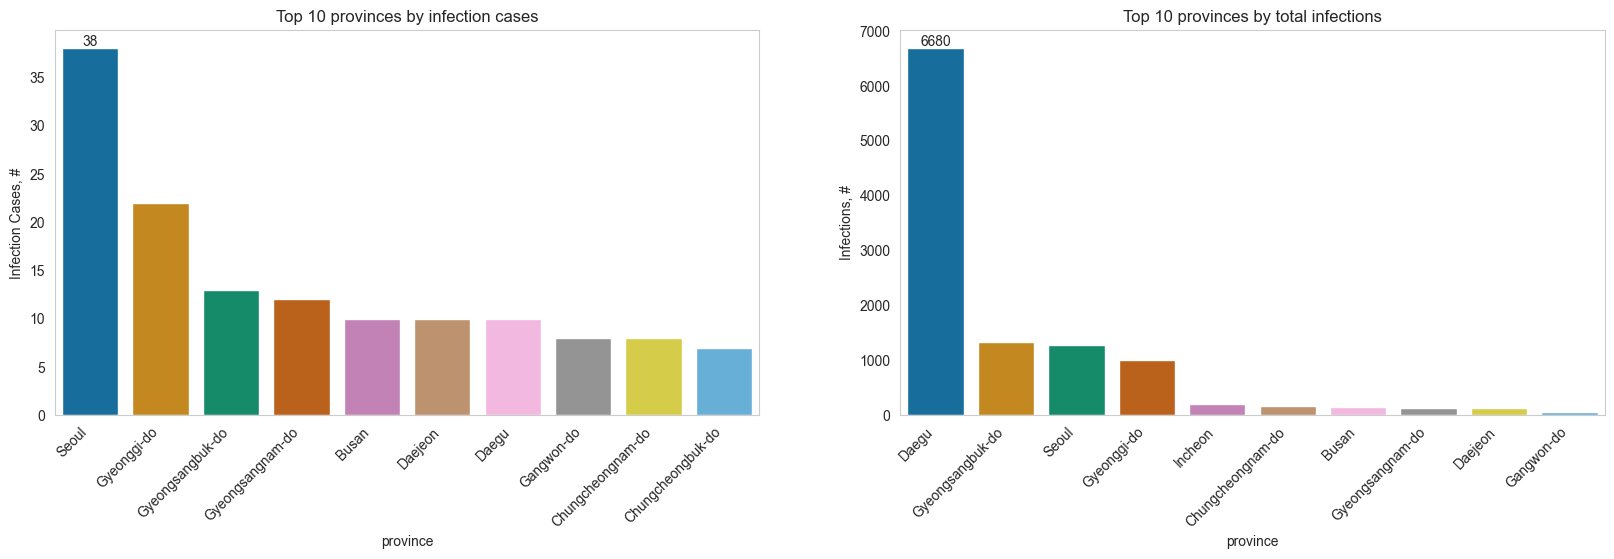

In [15]:
two_bar_subplots(df1_x=cases_province.index[:10], df2_x=infections_province.index[:10],
                 df1_y=cases_province.values[:10], df2_y=infections_province.values[:10],
                 title_1='Top 10 provinces by infection cases', title_2='Top 10 provinces by total infections',
                 y1_label='Infection Cases, #', y2_label='Infections, #',
                 x1_ticks=cases_province.index[:10], x2_ticks=infections_province.index[:10],
                 color_palette=color_palette)

From the infection cases overview, we can derive the following:
* The most **unique infection cases** occurred in *Seoul*, followed by *Gyeonggi-do* and *Gyeongsangbuk-do*;
* The **most infections** occurred in *Daegu*; The three aforementioned provinces with most infection cases have very similar total infections.

For our province-based analysis, let's focus on the top three provinces for now.

In [16]:
provinces = ['Seoul', 'Gyeonggi-do', 'Gyeongsangbuk-do']

#### Infection cases by City
For the top three Provinces, let's see which cities had the most infection cases.

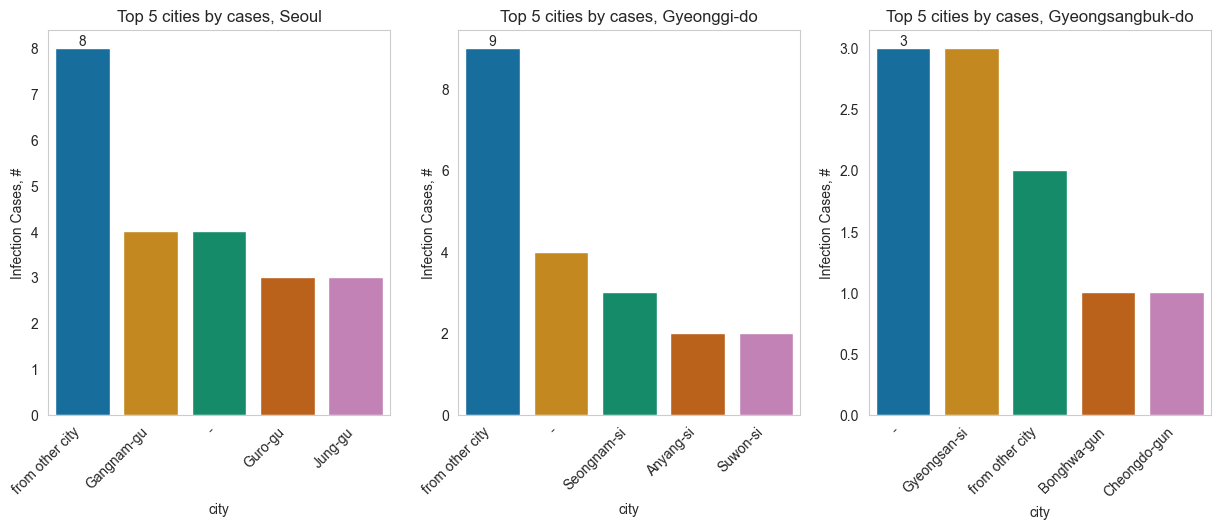

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, province in enumerate(provinces):
    cases_city = df_case[df_case['province']==province]
    cases_city = cases_city.groupby('city')['case_id'].count().sort_values(ascending=False)
    ax = sns.barplot(x=cases_city.index[:5], y=cases_city.values[:5], ax=axes[i], palette=color_palette)
    ax.bar_label(ax.containers[0])
    axes[i].set_title(f"Top 5 cities by cases, {province}")
    axes[i].set_xticklabels(rotation=45, labels=cases_city.index[:5], ha='right')
    axes[i].set_ylabel('Infection Cases, #');

Based on our city-level analysis, it seems that most infection cases occur **from other cities** - Koreans living in these provinces either get infected by visitors from other provinces or bring the infection over after visiting other provinces. The next step is to review where most cases came from for these provinces. Since we're analyzing at province level, let's focus on **total infections** rather than **infection cases** for now; We'll explore the latter at a bigger scale.

#### Total infections for Province by Outside Location

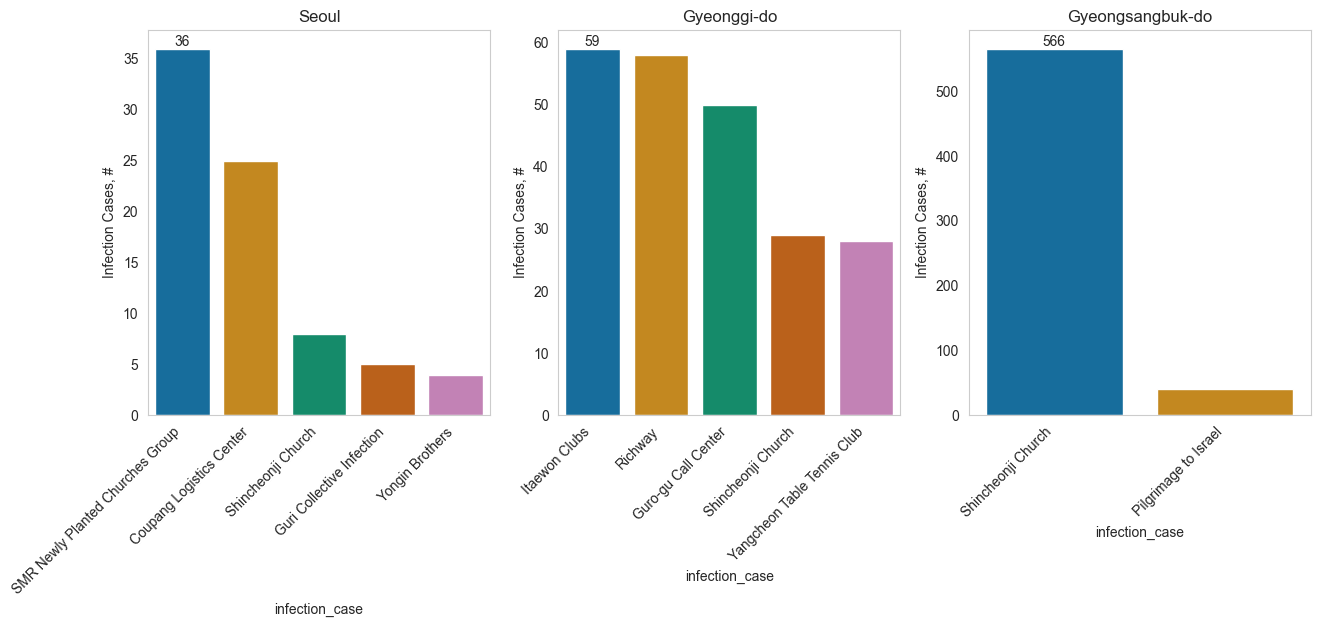

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, province in enumerate(provinces):
    infections_location = df_case[(df_case['province']==province) & (df_case['city']=='from other city')]
    infections_location = infections_location.groupby('infection_case')['confirmed'].sum()
    infections_location = infections_location.sort_values(ascending=False)
    ax = sns.barplot(x=infections_location.index[:5], y=infections_location.values[:5], ax=axes[i],
                     palette=color_palette)
    ax.bar_label(ax.containers[0])
    axes[i].set_title(f"{province}")
    axes[i].set_xticklabels(rotation=45, labels=infections_location.index[:5], ha='right')
    axes[i].set_ylabel('Infection Cases, #')

Here we have a much better perspective of which locations brought the most infections to these provinces:
* The largest outside infections for Seoul originated from Church activities;
* Gyeonggi-do has the most infections from *Itaewon Clubs*, *Richway* and *Guro-gu Call Center*;
* The large majority of outside cases for Gyeongsangbuk-do came from the Shincheonji Church; The second case is also related to religious activity.

#### Total infections for Province by Internal Location

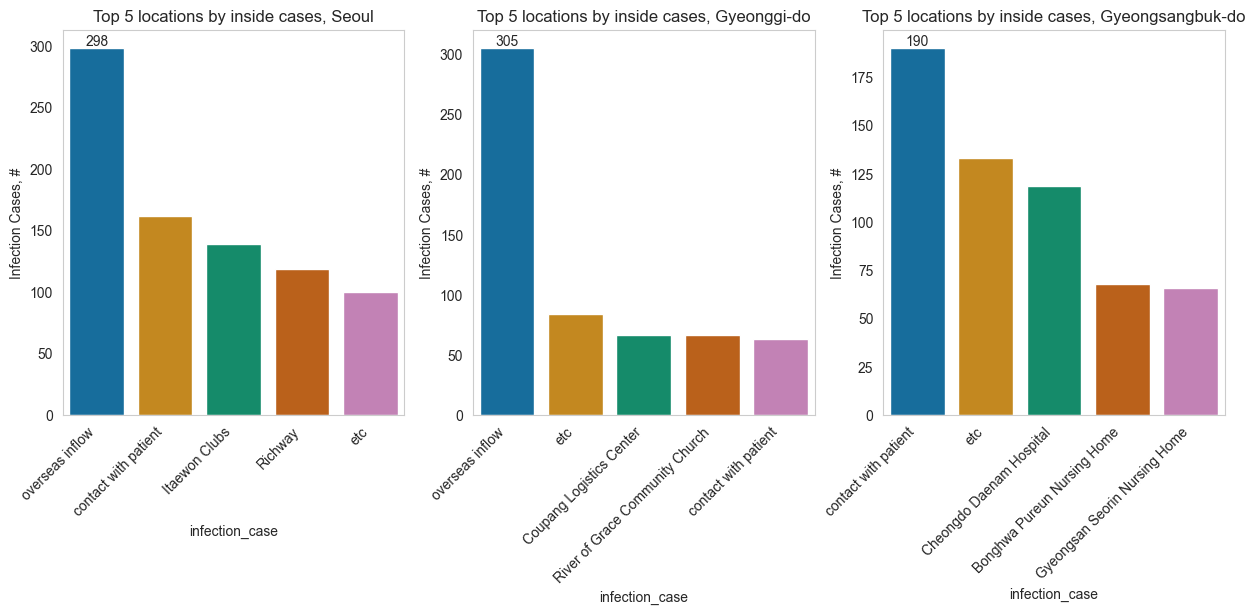

In [19]:
provinces = ['Seoul', 'Gyeonggi-do', 'Gyeongsangbuk-do']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, province in enumerate(provinces):
    infections_location = df_case[(df_case['province']==province) & (df_case['city']!='from other city')]
    infections_location = infections_location.groupby('infection_case')['confirmed'].sum()
    infections_location = infections_location.sort_values(ascending=False)
    ax = sns.barplot(x=infections_location.index[:5], y=infections_location.values[:5], ax=axes[i],
                     palette=color_palette)
    ax.bar_label(ax.containers[0])
    axes[i].set_title(f"Top 5 locations by inside cases, {province}")
    axes[i].set_xticklabels(rotation=45, labels=infections_location.index[:5], ha='right')
    axes[i].set_ylabel('Infection Cases, #')

Here, we can note the following:
* Overseas inflow infections are most relevant for Seoul and Gyeonggi-do;
* Itaewon Clubs and Richway are prominent in Seoul internal infections and have contributed to external infections in Gyeonggi-do as well;
* The top three internal locations for Gyeongsangbuk-do are Medical Facilities, including high total infections from contact with patients.

#### Province Overview Summary
1. The top three provinces by infection cases: Seoul, Gyeonggi-do and Gyeongsangbuk-do.
2. The top four provinces by total infections: Daegu, Seoul, Gyeonggi-do and Gyeongsangbuk-do.
3. Internal Seoul and Gyeonggi-do infections mainly originate from overseas inflow, Gyeongsangbuk-do infections arise from medical facilities and contact with patients
4. Outside infections for these provinces mainly come from Church activities and Clubs.

### Infections by Location
Unlike Province analysis, Locations are much more concrete and may help us derive points for our action plan, alongside the concrete questions.

In [20]:
cases_location_count = df_case.groupby('infection_case')['case_id'].count().sort_values(ascending=False)
cases_location_sum = df_case.groupby('infection_case')['confirmed'].sum().sort_values(ascending=False)

#### Top 10 Locations by Infection Cases & Total Infections

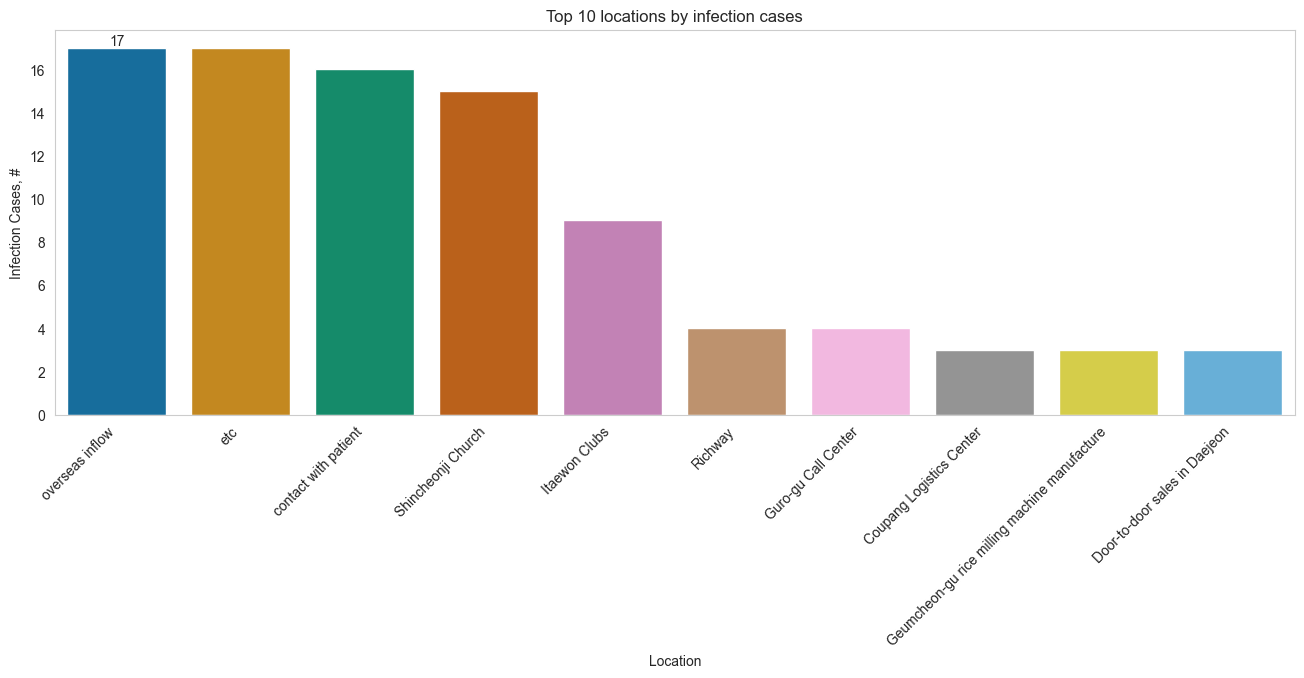

In [21]:
plt.figure(figsize=(16, 5))
ax = sns.barplot(x=cases_location_count.index[:10], y=cases_location_count.values[:10], palette=color_palette)
ax.bar_label(ax.containers[0])
plt.xlabel('Location')
plt.ylabel('Infection Cases, #')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 locations by infection cases');

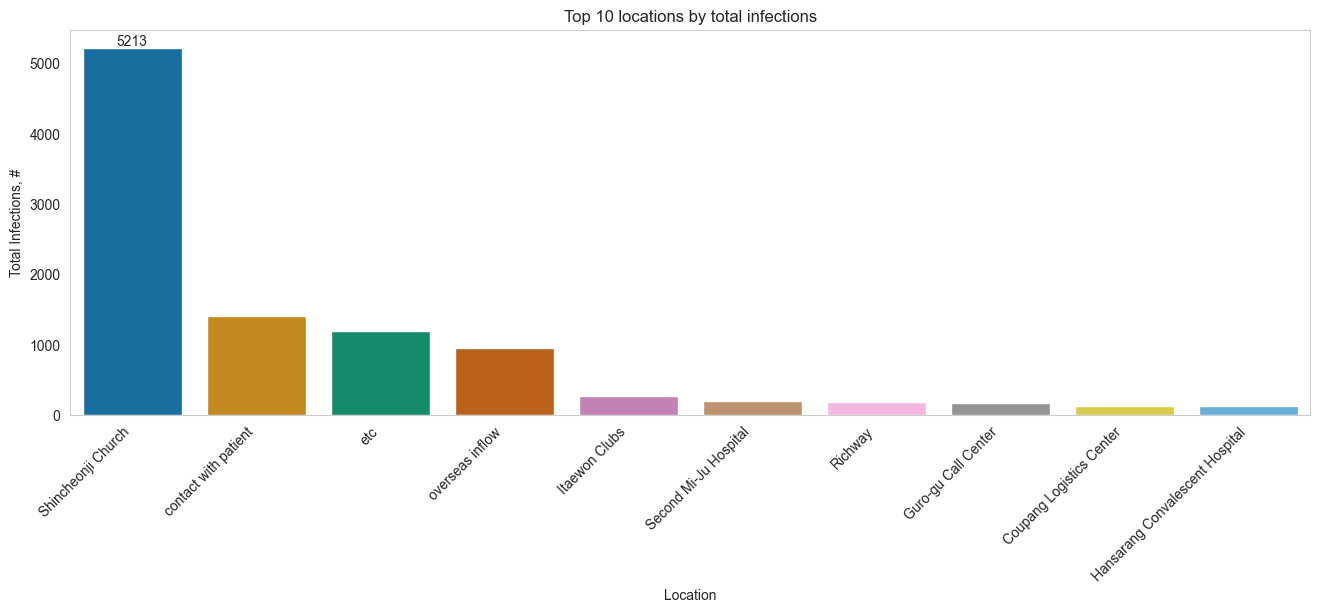

In [22]:
plt.figure(figsize=(16, 5))
ax = sns.barplot(x=cases_location_sum.index[:10], y=cases_location_sum.values[:10], palette=color_palette)
ax.bar_label(ax.containers[0])
plt.xlabel('Location')
plt.ylabel('Total Infections, #')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 locations by total infections');

From the infection cases overview, we can derive the following:
* Majority of cases originate from *Overseas inflow*, *Non-categorized* or due to *Contact with patients*;
* The biggest amount of unique cases came from *Shincheonji Church*, *Itaewon Clubs*, *Richway* and the *Guro-gu Call Center*;
* The *Shincheonji Church* has the largest total infections out of any location / infection category.

### Infections by Province and Location - Findings
We've uncovered a lot of solid points of discussion! Answering these questions will give us a solid start in our Pandemic Prevention Plan.

1. Review the impact of Church Activities to **infection cases** & **total infections**
2. Investigate the origin of *Itaewon Clubs*, *Richway* and *Guro-gu Call Center* to **infection cases** & **total infections**
3. Identify which locations are most susceptible to *overseas inflow* infections;
4. Identify which locations have the largest *contact with patient* and *Medical institutions* related infections.

#### Impact of Church Activities
For this analysis, we will use the `location_category` column that we created previously. Let's look at the distribution of total cases and total infections for each location category.

In [23]:
loc_category_sum = df_case.groupby('location_category')['confirmed'].sum().sort_values(ascending=False)
loc_category_cases = df_case.groupby('location_category')['confirmed'].count().sort_values(ascending=False)

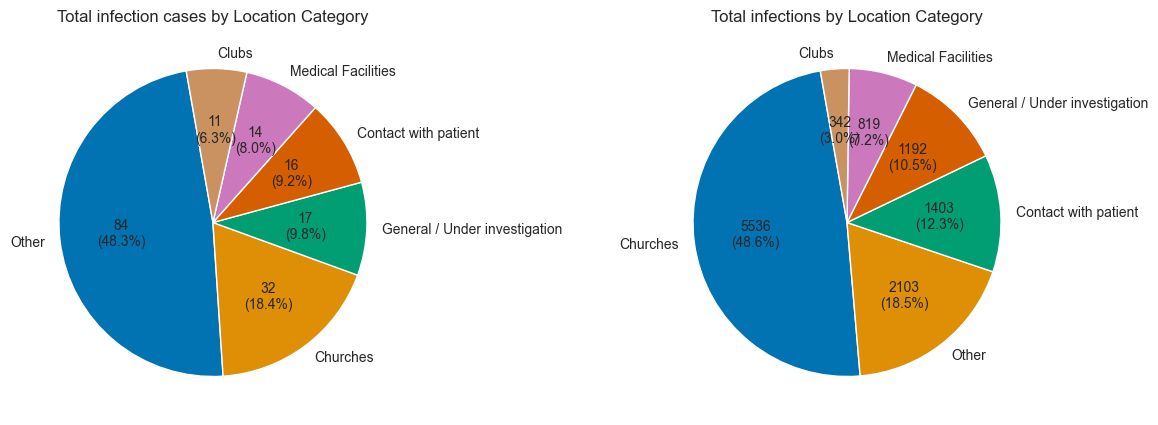

In [24]:
two_pie_subplots(df1=loc_category_cases, df2=loc_category_sum,
                 df1_labels=loc_category_cases.index, df2_labels=loc_category_sum.index,
                 title_1='Total infection cases by Location Category',
                 title_2='Total infections by Location Category',
                 color_palette=color_palette)

The pie charts indicate that Churches contributed to **almost 50% of all COVID infections**! In terms of total cases, it had the **biggest amount of categorized locations**, with 32 unique cases registered to Churches.
Let's take a look on which Churches contributed the most in terms of total infections and which resulted in the most unique infection cases.

In [25]:
df_case_churches = df_case[df_case['location_category']=='Churches']
churches_infections = df_case_churches.groupby('infection_case')['confirmed'].sum()
churches_infections = churches_infections.sort_values(ascending=False)
churches_cases = df_case_churches.groupby('infection_case')['confirmed'].count()
churches_cases = churches_cases.sort_values(ascending=False)

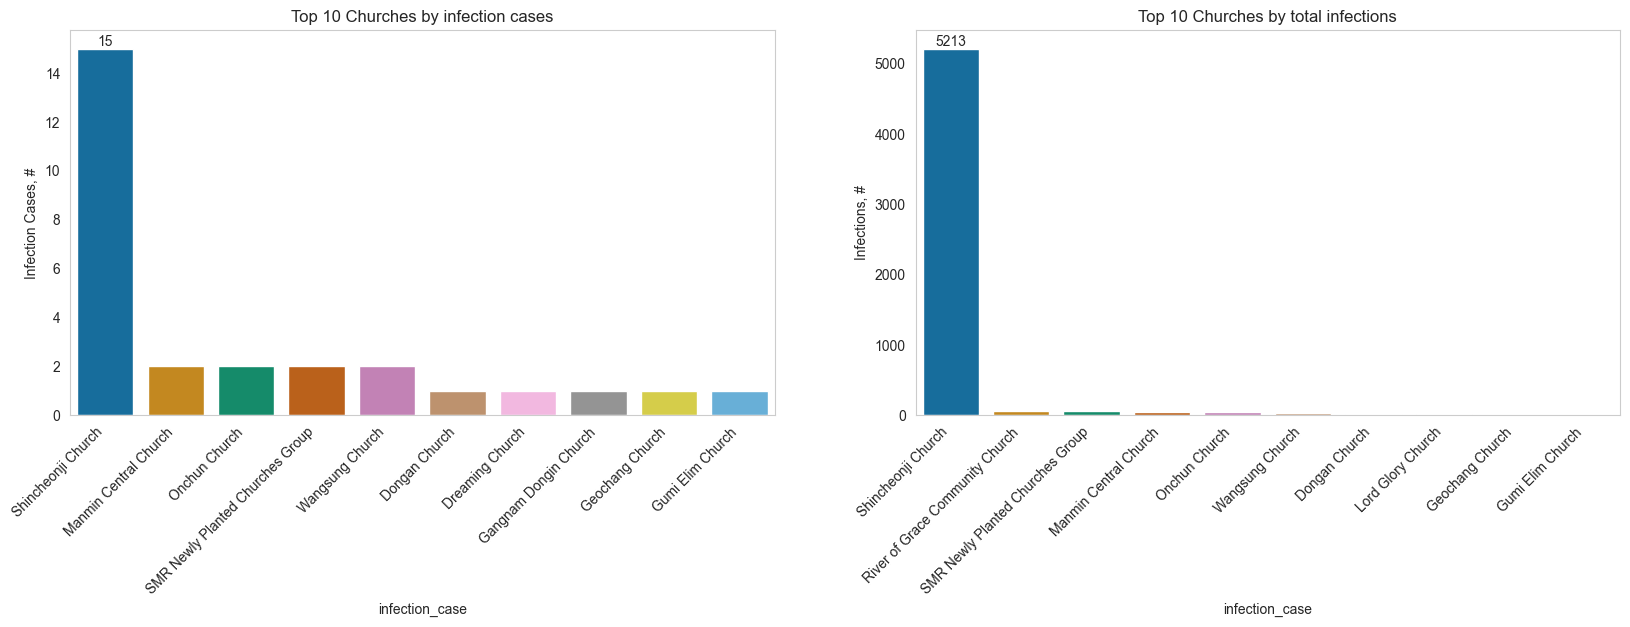

In [26]:
two_bar_subplots(df1_x=churches_cases.index[:10], df2_x=churches_infections.index[:10],
                 df1_y=churches_cases.values[:10], df2_y=churches_infections.values[:10],
                 title_1='Top 10 Churches by infection cases', title_2='Top 10 Churches by total infections',
                 y1_label='Infection Cases, #', y2_label='Infections, #',
                 x1_ticks=churches_cases.index[:10], x2_ticks=churches_infections.index[:10],
                 color_palette=color_palette)

The biggest contributor to total infections from *Churches* and to South Korea's total infections was the **Shincheonji Church**. Other churches pale in comparison, both in terms of infection cases and total infections. The [article by CNN](https://edition.cnn.com/2020/02/26/asia/shincheonji-south-korea-hnk-intl/index.html) describes the Shincheonji Church community as very close-knit, crowded and strict in their attendance, regardless of physical well-being of the members.

With that in mind, let's add the first action to our <b style="color: red">Pandemic Prevention Plan</b>:
* Negotiate timely closure / distancing measures for church services and gatherings with religious groups.

#### Itaewon Clubs, Richway and Guro-gu Call Center
Besides Shincheonji Church, three other locations had notable infection rates in South Korea, both in terms of infection cases and total infections.
* **Itaewon Clubs** encompasses the clubs within the Itaewon neighbourhood in Yongsan-gu.
* **Richway** is a Seoul-based health product retailer.
* The **Guro-gu Call Center** is a call center in Guro-gu.

In [27]:
infection_locations = ['Itaewon Clubs', 'Richway', 'Guro-gu Call Center']
df_case_filtered = df_case[df_case['infection_case'].isin(infection_locations) & df_case['latitude']]
df_case_filtered[['province', 'city', 'infection_case']]

,province,city,infection_case
0,Seoul,Yongsan-gu,Itaewon Clubs
1,Seoul,Gwanak-gu,Richway
2,Seoul,Guro-gu,Guro-gu Call Center


We can see that all three locations are in the Seoul province, only in different cities.
* In the case of **Itaewon Clubs**, club activities during a pandemic should be assessed.
* For Richway and Guro-gu Call Center, workplace health & safety measures should be ensured.

Before we make additions to our action plan, let's review which clubs contributed to most infections, alongside Itaewon Clubs.

In [28]:
df_case_clubs = df_case[df_case['location_category']=='Clubs']
clubs_infections = df_case_clubs.groupby('infection_case')['confirmed'].sum().sort_values(ascending=False)
for club, infections in clubs_infections.items():
    print(f"{club} with {infections} infections.")

Itaewon Clubs with 271 infections.
Yangcheon Table Tennis Club with 71 infections.


Fortunately, only two club-related locations had confirmed infection outbreaks, the latter being a sports club. Let's formulate our two <b style="color: red">Pandemic Prevention Plan</b> actions as follows:
* Monitor night club activity in the city of Yongsan-gu; The clubs have a relatively high infection rate and spread to other cities.
* Provide recommendations for workplace health & safety during the pandemic, perform audits and assessments.

#### Overseas Inflow
We have indicated a concerning amount of infections in Seoul and Gyeonggi-do related to overseas inflow. Unfortunately, the dataset does not provide us with specific cities in which the overseas inflow infections happened, but, nontheless, let's take a look at this category and identify whether any other provinces are most susceptible to this form of infection. With that information, we can identify coastal cities / cities with major airports.

In [29]:
df_case_overseas = df_case[df_case['infection_case']=='overseas inflow']
overseas_infections = df_case_overseas.groupby('province')['confirmed'].sum().sort_values(ascending=False)
province_location = {}
overseas_infections_provinces = list(overseas_infections.index)
for province in overseas_infections_provinces:
    location = df_region.loc[df_region['province'] == province, ['latitude', 'longitude']].iloc[0]
    latitude, longitude = location
    province_location[province] = (latitude, longitude)

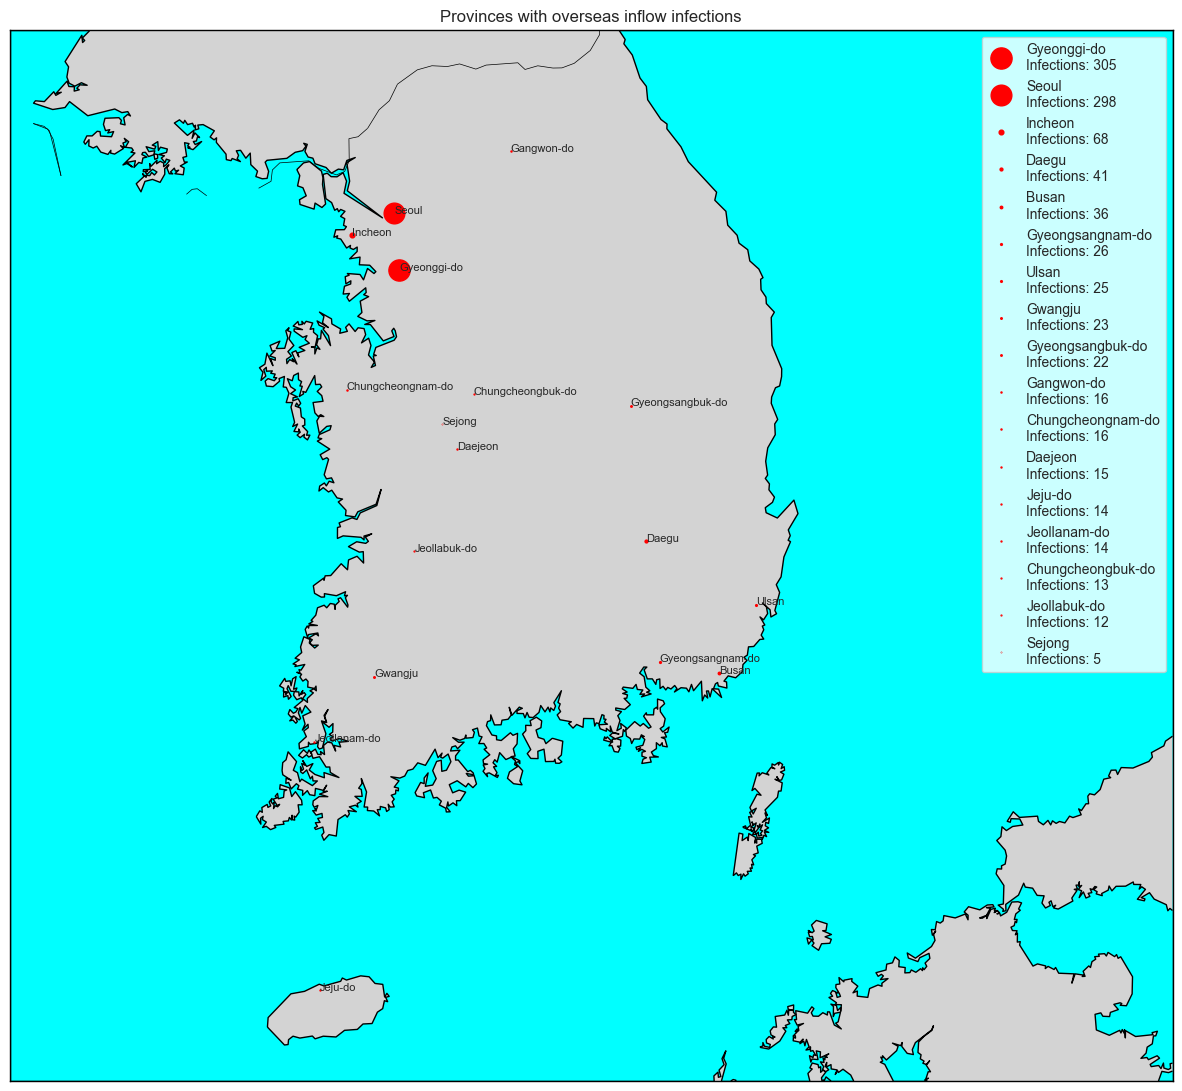

In [30]:
basemap_map(scaling_factor=20, df=overseas_infections, min_lat=min_lat, max_lat=max_lat,
            min_lon=min_lon, max_lon=max_lon, labels_dict=province_location,
            title='Provinces with overseas inflow infections')

Just as previously observed, Gyenonggi-do, Seoul have the highest overseas inflow infections in all South Korea. Incheon and Daegu are the 3rd and 4th provinces. In essence, it seems that **the northwest South Korea coastline around the Capital City is the most susceptible to overseas infections.**

Potential cities may include:
* Incheon City: Houses Incheon International Airport, one of South Korea's largest and busiest airports, serving as a major international gateway.
* Gimpo (Gyeonggi-do): Hosts Gimpo International Airport, another major airport in South Korea serving domestic flights and some international routes.
* Seoul: Hosts Gimpo International Airport and Incheon International Airport. Incheon Airport is mainly located in Incheon City but serves the greater Seoul metropolitan area.

Let's add an action to our <b style="color: red">Pandemic Prevention Plan</b>:
* Ensure stringent pandemic prevention procedures in northwestern South Korean coastal and airport cities surrounding the Capital.

#### Medical Institutions' and contact infections
We've found a large amount of infections in Medical Facilities and through contact with patients within the Gyeongsangbuk-do province. High infections of such type can indicate lack of safety precautions within the medical facilities or lax patients' isolation controls. Once again, the category 'contact with patient', does not have a city specified, only the province. Let's see which provinces have the largest infection rates and see whether it correlates with infections within medical facilities.

In [31]:
df_case_patients = df_case[df_case['infection_case']=='contact with patient']
patients_infections = df_case_patients.groupby('province')['confirmed'].sum().sort_values(ascending=False)
province_location_patients = {}
patients_infections_provinces = list(patients_infections.index)
for province in patients_infections_provinces:
    location = df_region.loc[df_region['province'] == province, ['latitude', 'longitude']].iloc[0]
    latitude, longitude = location
    province_location_patients[province] = (latitude, longitude)

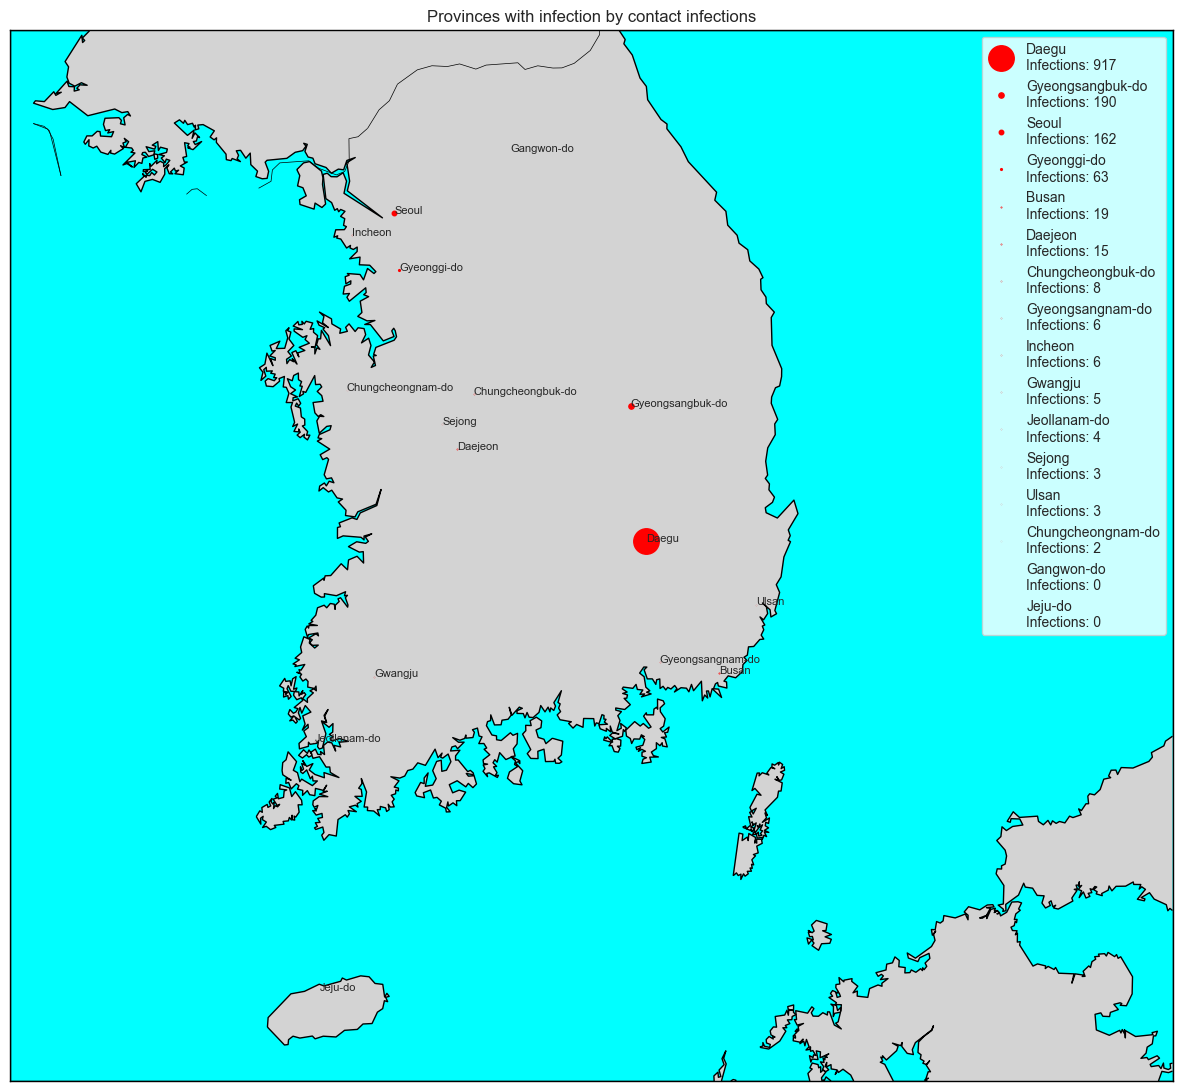

In [32]:
basemap_map(scaling_factor=50, df=patients_infections, min_lat=min_lat, max_lat=max_lat,
            min_lon=min_lon, max_lon=max_lon, labels_dict=province_location_patients,
            title='Provinces with infection by contact infections')

In [33]:
df_case_medical = df_case[df_case['location_category']=='Medical Facilities']
medical_infections = df_case_medical.groupby(['province'])['confirmed'].sum().sort_values(ascending=False)
province_location_medical = {}
medical_infections_provinces = list(medical_infections.index)
for province in medical_infections_provinces:
    location = df_region.loc[df_region['province'] == province, ['latitude', 'longitude']].iloc[0]
    latitude, longitude = location
    province_location_medical[province] = (latitude, longitude)

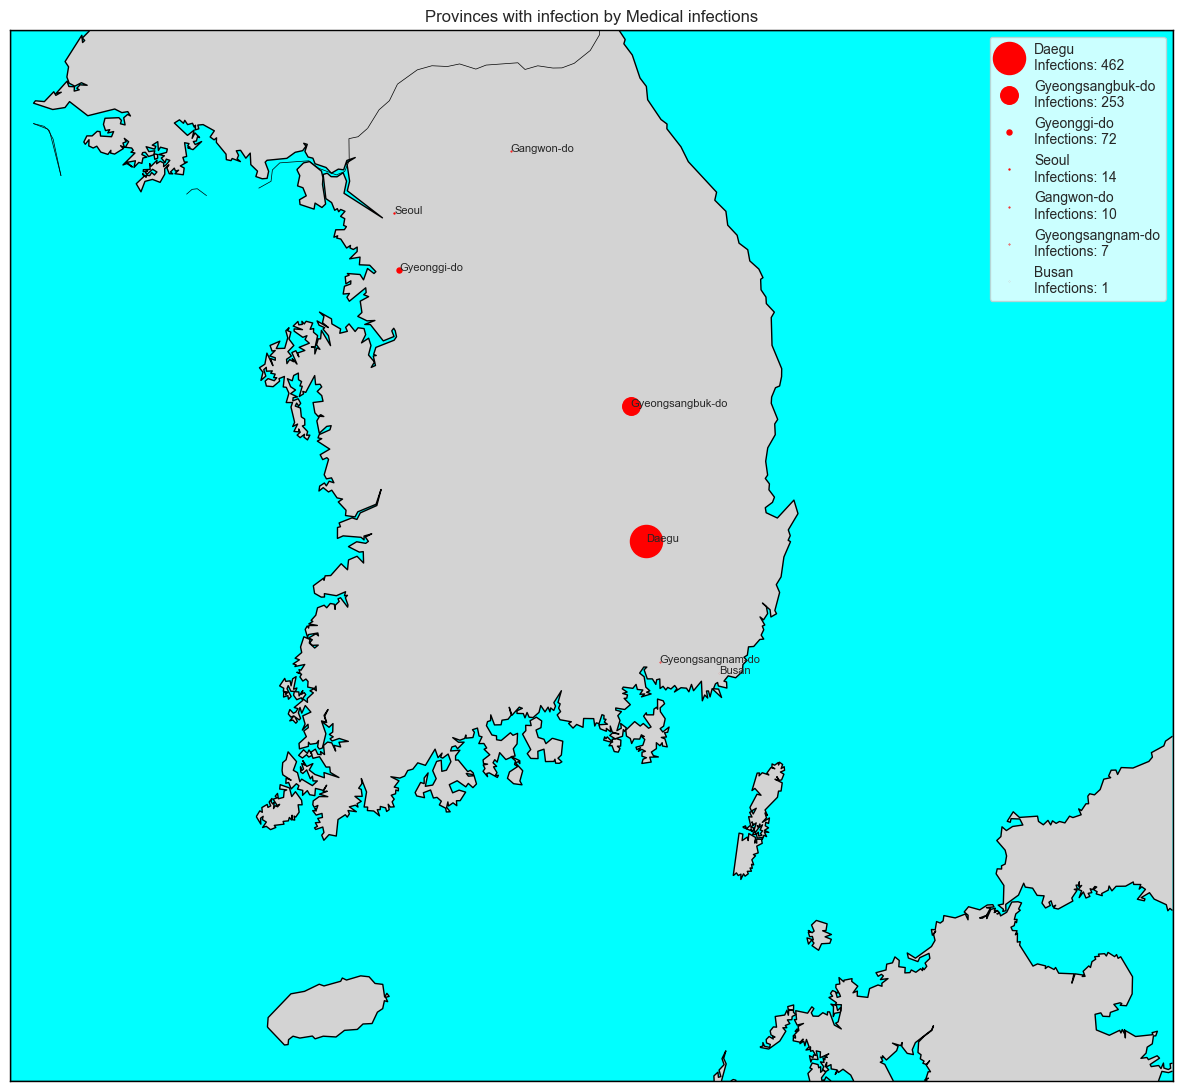

In [34]:
basemap_map(scaling_factor=20, df=medical_infections, min_lat=min_lat, max_lat=max_lat,
            min_lon=min_lon, max_lon=max_lon, labels_dict=province_location_medical,
            title='Provinces with infection by Medical infections')

In both cases, **Daegu** and **Gyeongsangbuk-do** have the highest infections from contact with patients and within medical institutions. Let's look at the top 10 medical institutions in South Korea by total infections.

In [35]:
medical_infections = df_case_medical.groupby(['infection_case'])['confirmed'].sum()
medical_infections = medical_infections.sort_values(ascending=False).reset_index()

In [36]:
# Map the Hospitals to cities
hosp_city = {}
for hosp in set(medical_infections['infection_case']):
    hosp_city[hosp] = df_case_medical.loc[
        (df_case_medical['city'] != 'from other city') &
        (df_case_medical['infection_case'] == hosp),
        'province'].iloc[0]
medical_infections['province'] = medical_infections['infection_case'].map(hosp_city)

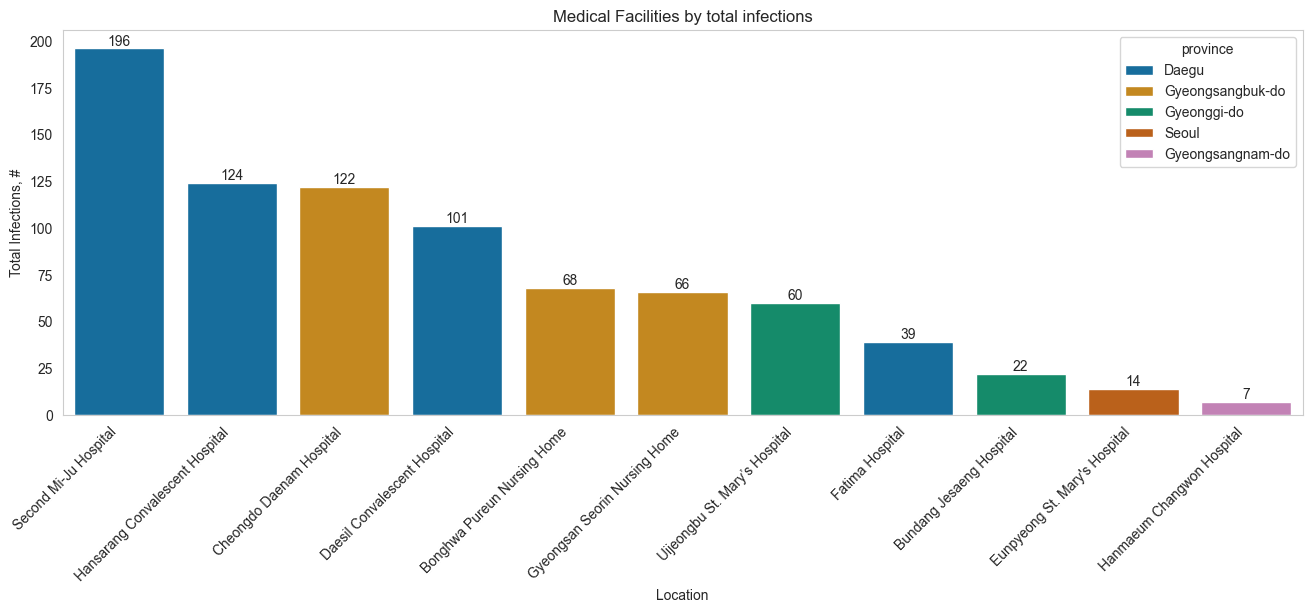

In [37]:
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=medical_infections, x='infection_case', y='confirmed', hue='province',
                 palette=color_palette, dodge=False)
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Location')
plt.ylabel('Total Infections, #')
plt.xticks(rotation=45, ha='right')
plt.title('Medical Facilities by total infections');

As expected, the top Medical Facilities by total infections are from either **Daegu** or **Gyengsangbuk-do**. The outbreaks in these hospitals may indicate that there were not enough safety measures to isolate patients or the hospitals were overencumbered by the influx of people having the symptoms (huge total infections in Daegu). Let's add another point to our <b style="color: red">pandemic prevention plan</b>:
* Ensure proper patients' isolation, safety measures for medical employees in hospitals. Put high focus on the hospitals within **Daegu**, **Gyengsangbuk-do** and **Gyeonggi-do** provinces.

### Patients' Data
Let's switch from cases data `df_case` to patients data with `df_patient`. After a brief look at the dataset, let's first try to answer the question: **Which age groups saw the highest mortality rates? Is the trend the same among all provinces?**

#### Mortality among groups
Let's first aggregate the data to see mortality rates for each province by age group. If we find any province that stands out, we will take a deeper look into its cities.

In [38]:
deceased_patients = df_patient[df_patient['state'] == 'deceased']
age_mortality = deceased_patients.groupby('age')['age'].count().sort_values(ascending=False)

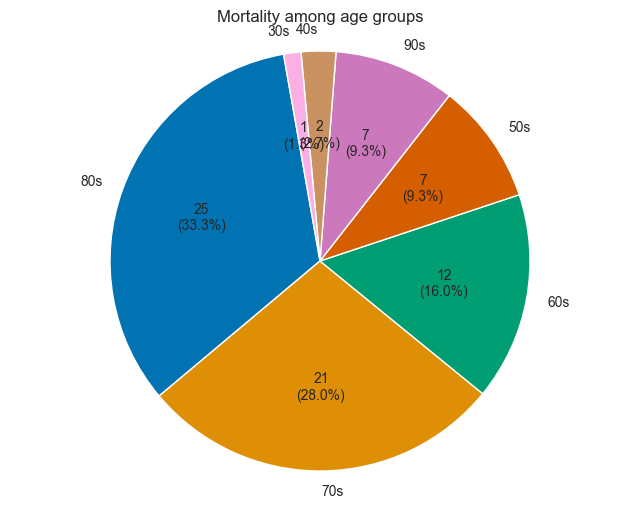

In [39]:
plt.figure(figsize=(8, 6))
plt.pie(age_mortality, labels=age_mortality.index, autopct=lambda pct: detailed_labels(pct, age_mortality),
        startangle=100, colors=color_palette)
plt.title('Mortality among age groups')
plt.axis('equal')
plt.show();

In essence, **almost 90% of all mortalities were of people above or the age of 60**. Let's also take a look at the infection case, i.e., how the deceased patients were infected, and the province in which the patients were infected.

In [40]:
deceased_patients.loc[deceased_patients['infection_case'].isnull(), 'infection_case'] = '-'
deceased_patients.loc[deceased_patients['city'].isnull(), 'city'] = '-'
case_mortality = deceased_patients.groupby('infection_case')['age'].count().sort_values(ascending=False)
province_mortality = deceased_patients.groupby('province')['age'].count().sort_values(ascending=False)

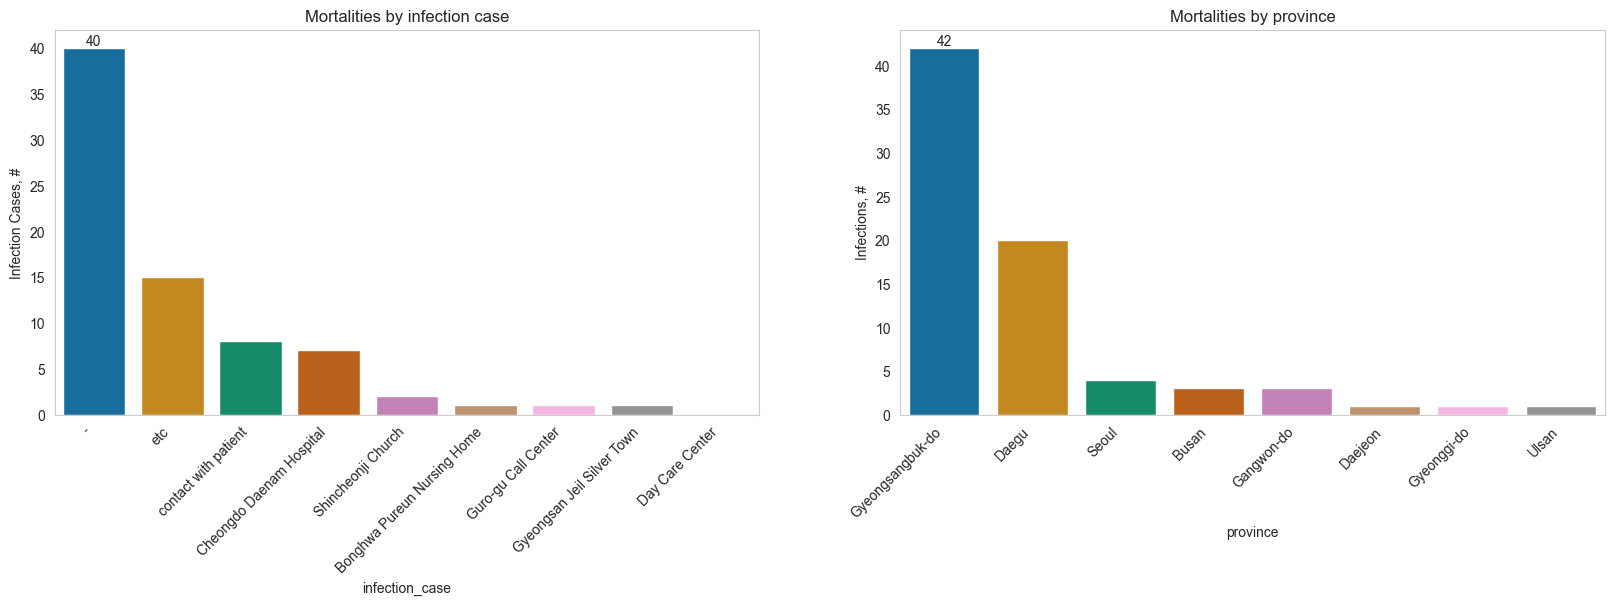

In [41]:
two_bar_subplots(df1_x=case_mortality.index, df2_x=province_mortality.index,
                 df1_y=case_mortality.values, df2_y=province_mortality.values,
                 title_1='Mortalities by infection case', title_2='Mortalities by province',
                 y1_label='Infection Cases, #', y2_label='Infections, #',
                 x1_ticks=case_mortality.index, x2_ticks=province_mortality.index, color_palette=color_palette)

Majority of mortalities are under investigation or not specified. The third and fourth categories are contacts with patients and from a Medical Facility. The bar chart on the right displays recently discussed provinces of Gyengsangbuk-do and Daegu, shown to have significant issues with medical facilities related infections. To tie these two occurrences together, let's retrieve the cities of the most infectious hospitals found within these two provinces and see whether the cities match the cities in which majority of mortalities in these cities occurred.

In [42]:
city_mortality = deceased_patients.groupby(['city', 'province'])['state'].count().sort_values(ascending=False)
city_mortality = city_mortality.reset_index()
city_mortality = city_mortality[
                    (city_mortality['province'] == 'Daegu') |
                    (city_mortality['province'] == 'Gyeongsangbuk-do')]

In [43]:
hospital_city = {}
for hospital in medical_infections['infection_case']:
    hospital_city[hospital] = df_case.loc[
                    (df_case['infection_case'] == hospital) &
                    (df_case['city'] != 'from other city'),
                    'city'].iloc[0]
medical_infections['city'] = medical_infections['infection_case'].map(hospital_city)

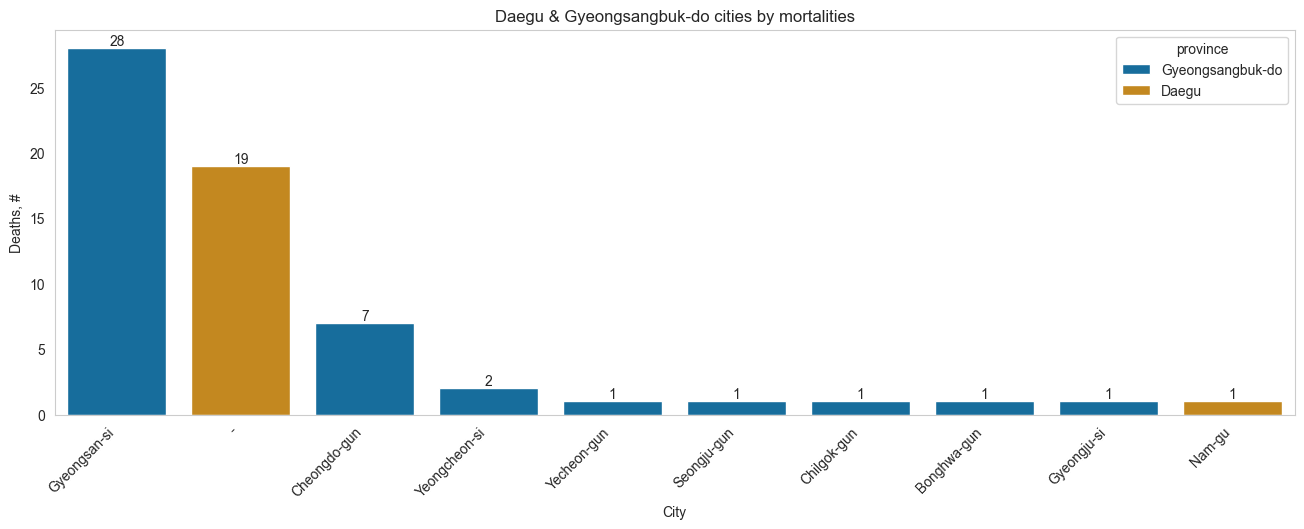

In [44]:
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=city_mortality, x='city', y='state', hue='province', dodge=False, palette=color_palette)
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('City')
plt.ylabel('Deaths, #')
plt.xticks(rotation=45, ha='right')
plt.title('Daegu & Gyeongsangbuk-do cities by mortalities');

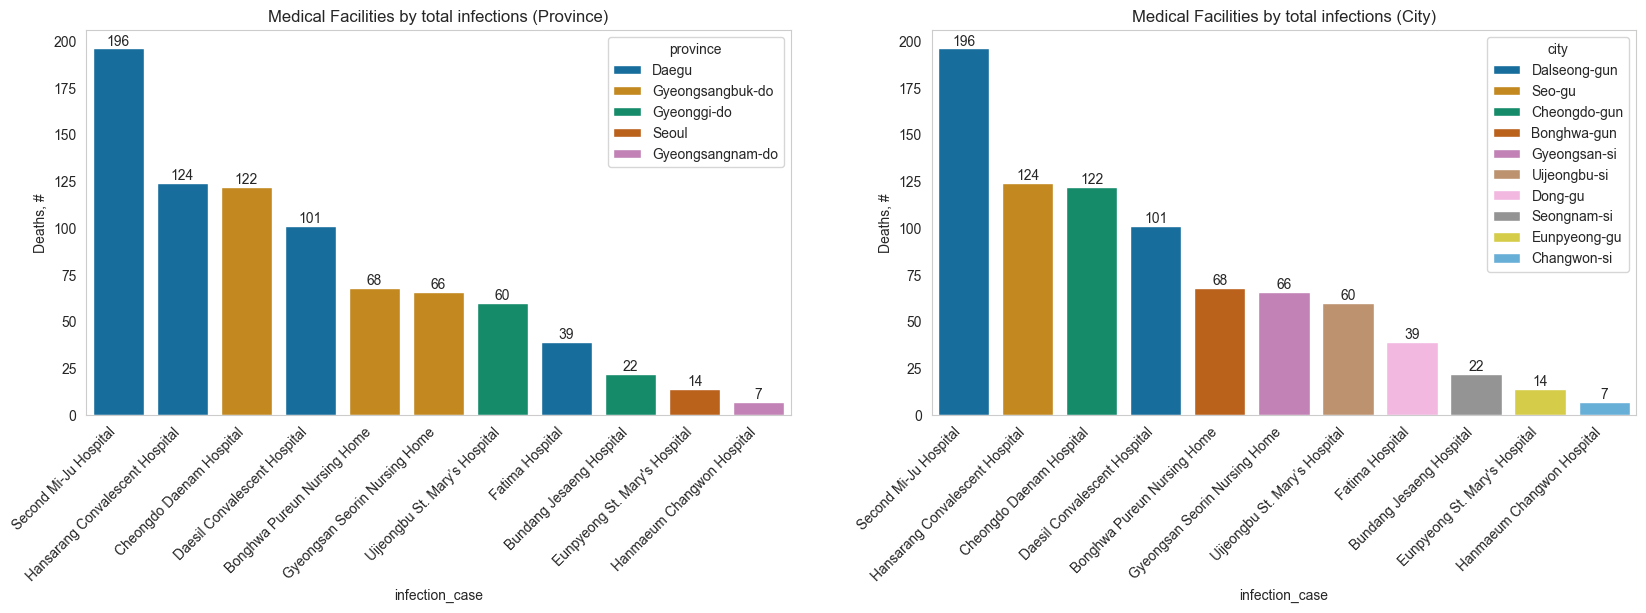

In [45]:
two_bar_subplots_legend(df1=medical_infections, df2=medical_infections,
                        x1='infection_case', x2='infection_case', y1='confirmed', y2='confirmed',
                        hue_1='province', hue_2='city',
                        title_1='Medical Facilities by total infections (Province)',
                        title_2='Medical Facilities by total infections (City)',
                        y1_label='Deaths, #', y2_label='Deaths, #',
                        x1_ticks=medical_infections['infection_case'],
                        x2_ticks=medical_infections['infection_case'],
                        color_palette=color_palette)

Gyeongsangbuk-do had the most COVID-related deaths in Gyeongsan-si and Chengdo-gun. The latter city has the third largest hospital in terms of total infections during the pandemic, largest in the province. As for Gyeongsan-si, it had an outbreak in a **nursing home** with 66 infections. Here we have a very specific sub-category of Medical Facilities that matches the age demographic of the deceased patients.
As for Daegu, majority of deaths within this province do not have cities attached to them; There might be two reasons:
* The deaths are not of Daegu citizens, but visitors to Daegu. For instance, some infections from the Shincheonji Church might have translated to hospitalization (two biggest medical facilities in terms of infections are in Daegu) and death;
* The deaths were not properly documented.

Regardless whether the large infection counts within medical facilities in Daegu were caused due to the surge of infections from Shincheonji Church or poor preparation for the pandemic, the nursing homes infections, the age demographic of the deceased patients and deaths in Gyeongsangbuk-do have correlation. We can add an extra point to the <b style="color: red">Pandemic Prevention Plan</b>:
* Alongside the proper safety measures in hospitals, ensure stringent measures within nursing homes, that house the age demographics most susceptible to disease-related mortality.

# Conclusion

## Findings
We have explored a lot of location-based data, navigated through the list of cases and took a dive into the patients' information to gather data on most vulnerable subset of the population. Let's summarize our findings by going through each of the points noted in our Pandemic Prevention Plan.

### The Pandemic Prevention Plan
1. Churches contributed to the largest share of infections. Negotiate timely closure of church services and gatherings with religious groups, especially those with largest gatherings.
2. Night life, especially in the city of Yonhsan-gu, had a noticeable portion of total infections. Monitor night club activity, especially in high domestic and external tourist locations; The clubs have a relatively high infection rate and spread to other cities. 
3. Several workplaces saw a surge in infections. Provide recommendations for workplace health & safety during the pandemic, perform audits and assessments during flu seasons.
4. Overseas inflows were the reason behind many infection cases. Ensure stringent pandemic prevention procedures in northwestern South Korean coastal and airport cities surrounding the Capital.
5. Several medical facilities in the Southeastern part of the country had big infection numbers. Ensure proper patients' isolation, safety measures for medical employees in hospitals. Put high focus on the hospitals within Daegu, Gyengsangbuk-do and Gyeonggi-do provinces.
6. A noticeable amount of infections occurred in nursing homes, some of which were situated in the cities with most pandemic-related deaths. Ensure stringent measures within nursing homes, that house the age demographics most susceptible to disease-related mortality.

The plan puts a heavy focus on pre-work before a pandemic hits and proper monitoring measures during the pandemic. Regardless of whether the threat of a global-scale pandemic is probable in the near future, the pre-work steps that implement safety measures within the aforementioned locations will help reduce sicknesses during the flu seasons and reduce the load on medical facilities.

## Considerations and Improvements for Future Studies
### Considerations
1. The entirety of the pandemic data (dataset provides data until 2020-06-30)
2. The scope of the analysis and the contents of the dataset
3. The fullness of data (missing fields)

#### Improvements for Similar Studies
1. Larger time period that encompasses the entire timeline of the pandemic
2. Policy-Location analysis to see whether provinces/cities/locations had reductions in infections after policies were enacted
3. Analysis of other developed countries